In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

from pymc_extras.inference.advi.autoguide import AutoDiagonalNormal
from pymc_extras.inference.advi.training import SVIModule, SVITrainer
from typing import Any
import arviz as az

In [2]:
with pm.Model() as m:
    X = pm.Normal("X", 0, 1, size=(100, 3))
    alpha = pm.Normal("alpha", 0, 10)
    beta = pm.Normal("beta", 0, 5, size=(3,))

    mu = alpha + X @ beta
    sigma = pm.HalfNormal("sigma", 1)
    y = pm.Normal("y", mu=mu, sigma=sigma)

    prior = pm.sample_prior_predictive(random_seed=38)

Sampling: [X, alpha, beta, sigma, y]


In [3]:
draw = 123
true_params = {}
true_params["alpha"] = prior.prior.alpha.sel(chain=0, draw=draw).values
true_params["beta"] = prior.prior.beta.sel(chain=0, draw=draw).values
true_params["sigma"] = prior.prior.sigma.sel(chain=0, draw=draw).values

X_data = prior.prior.X.sel(chain=0, draw=draw).values
y_data = prior.prior.y.sel(chain=0, draw=draw).values

In [4]:
true_params

{'alpha': array(11.82213038),
 'beta': array([-0.92518728,  0.27270752, -0.20081106]),
 'sigma': array(0.40007044)}

In [5]:
m_obs = pm.observe(pm.do(m, {X: X_data}), {"y": y_data})

In [6]:
with m_obs:
    idata = pm.sample(mp_ctx="spawn")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [7]:
class SGDOptimizer:
    def __init__(self, learning_rate: float = 1e-5):
        self.learning_rate = learning_rate

    def init(self, params: dict[str, np.ndarray]) -> None:
        return None

    def update(
        self,
        grads: dict[str, np.ndarray],
        state: None,
        params: dict[str, np.ndarray],
    ) -> tuple[dict[str, np.ndarray], None]:
        updated_params = {k: v - self.learning_rate * grads[k] for k, v in params.items()}
        return updated_params, state


class NormalModel(SVIModule):
    def configure_guide(self, model):
        return AutoDiagonalNormal(model)

    def configure_optimizer(self, params: dict[str, np.ndarray]) -> tuple[Any, dict[str, Any]]:
        optimizer = SGDOptimizer(learning_rate=1e-5)
        opt_state = optimizer.init(params)
        return optimizer, opt_state

    def apply_gradients(
        self,
        params: dict[str, np.ndarray],
        grads: dict[str, np.ndarray],
        optimizer: Any,
        optimizer_state: dict[str, Any],
    ):
        updated_params, updated_opt_state = optimizer.update(grads, optimizer_state, params)
        return updated_params, updated_opt_state


def plot_loss_history(state, window_size=100):
    kernel = np.full(window_size, 1 / window_size)
    loss_history = np.stack(state.loss_history)
    plt.plot(np.convolve(loss_history, kernel, mode="valid"))

In [8]:
svi_trainer = SVITrainer(module=NormalModel(), compile_kwargs={"mode": "NUMBA"})

In [9]:
svi_state = svi_trainer.fit(n_steps=2000, model=m_obs, draws_per_step=500)

Output()

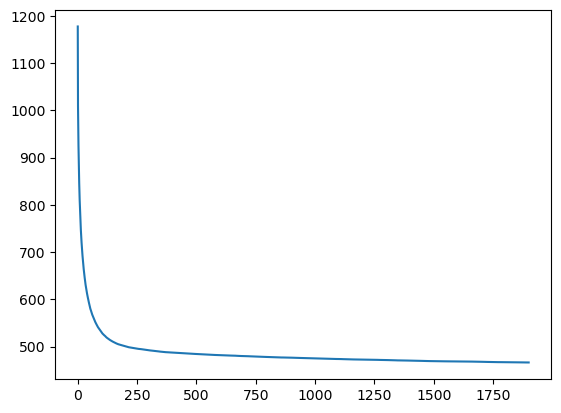

In [10]:
plot_loss_history(svi_state)

Output()

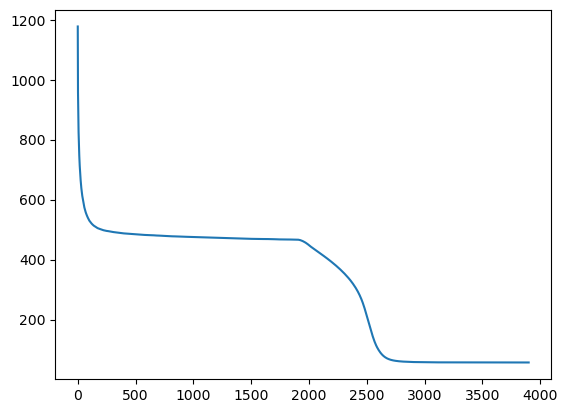

In [11]:
svi_trainer._optimizer.learning_rate = 1e-3
svi_state = svi_trainer.fit(state=svi_state, n_steps=2000, model=m_obs, draws_per_step=500)
plot_loss_history(svi_state)

In [12]:
def inverse_softplus(x):
    return np.log(np.expm1(x))


mcmc_param_values = {}
mcmc_param_values["sigma_loc"] = np.log(idata.posterior["sigma"]).mean(("chain", "draw")).values
mcmc_param_values["sigma_scale"] = inverse_softplus(
    np.log(idata.posterior["sigma"]).std(("chain", "draw"))
).values

for param in ("beta", "alpha"):
    mcmc_param_values[f"{param}_loc"] = idata.posterior[param].mean(("chain", "draw")).values
    mcmc_param_values[f"{param}_scale"] = inverse_softplus(
        idata.posterior[param].std(("chain", "draw"))
    ).values

In [13]:
optimized_params = svi_state.params
optimized_params

{'sigma_loc': np.float64(-1.0655292011551),
 'sigma_scale': np.float64(-2.612317028399908),
 'beta_loc': array([-0.90521353,  0.27185511, -0.16291681]),
 'beta_scale': array([-3.28822539, -3.30732687, -3.19326929]),
 'alpha_loc': np.float64(11.779730784087874),
 'alpha_scale': np.float64(-3.3057072458331076)}

In [14]:
mcmc_param_values

{'sigma_loc': array(-1.06726121),
 'sigma_scale': array(-2.57409363),
 'beta_loc': array([-0.90878155,  0.27347309, -0.1599979 ]),
 'beta_scale': array([-3.32057753, -3.32382148, -3.25170015]),
 'alpha_loc': array(11.7819593),
 'alpha_scale': array(-3.33534358)}

In [15]:
with m_obs:
    idata_vi = svi_trainer.sample_posterior(draws=1000, state=svi_state)

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

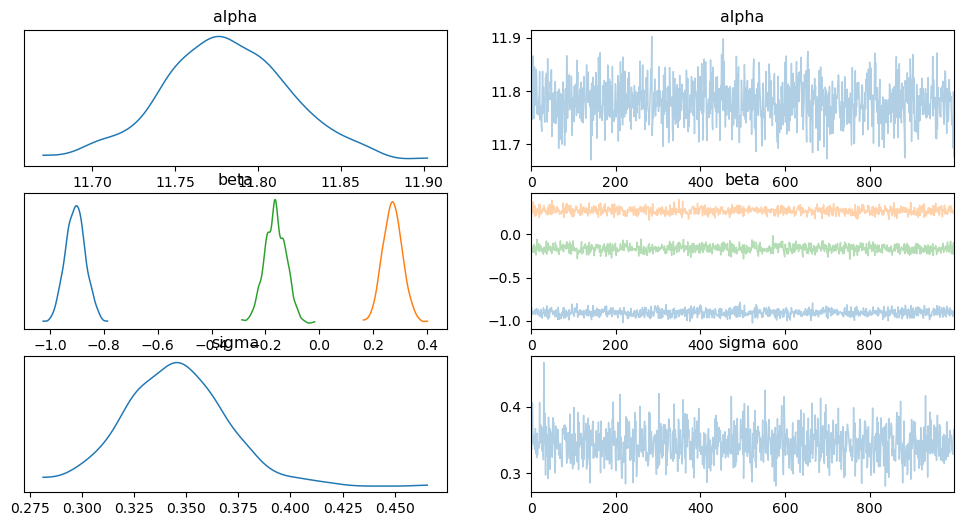

In [16]:
az.plot_trace(idata_vi, var_names=["alpha", "beta", "sigma"])

In [17]:
true_params

{'alpha': array(11.82213038),
 'beta': array([-0.92518728,  0.27270752, -0.20081106]),
 'sigma': array(0.40007044)}

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'sigma'}>, <Axes: >]], dtype=object)

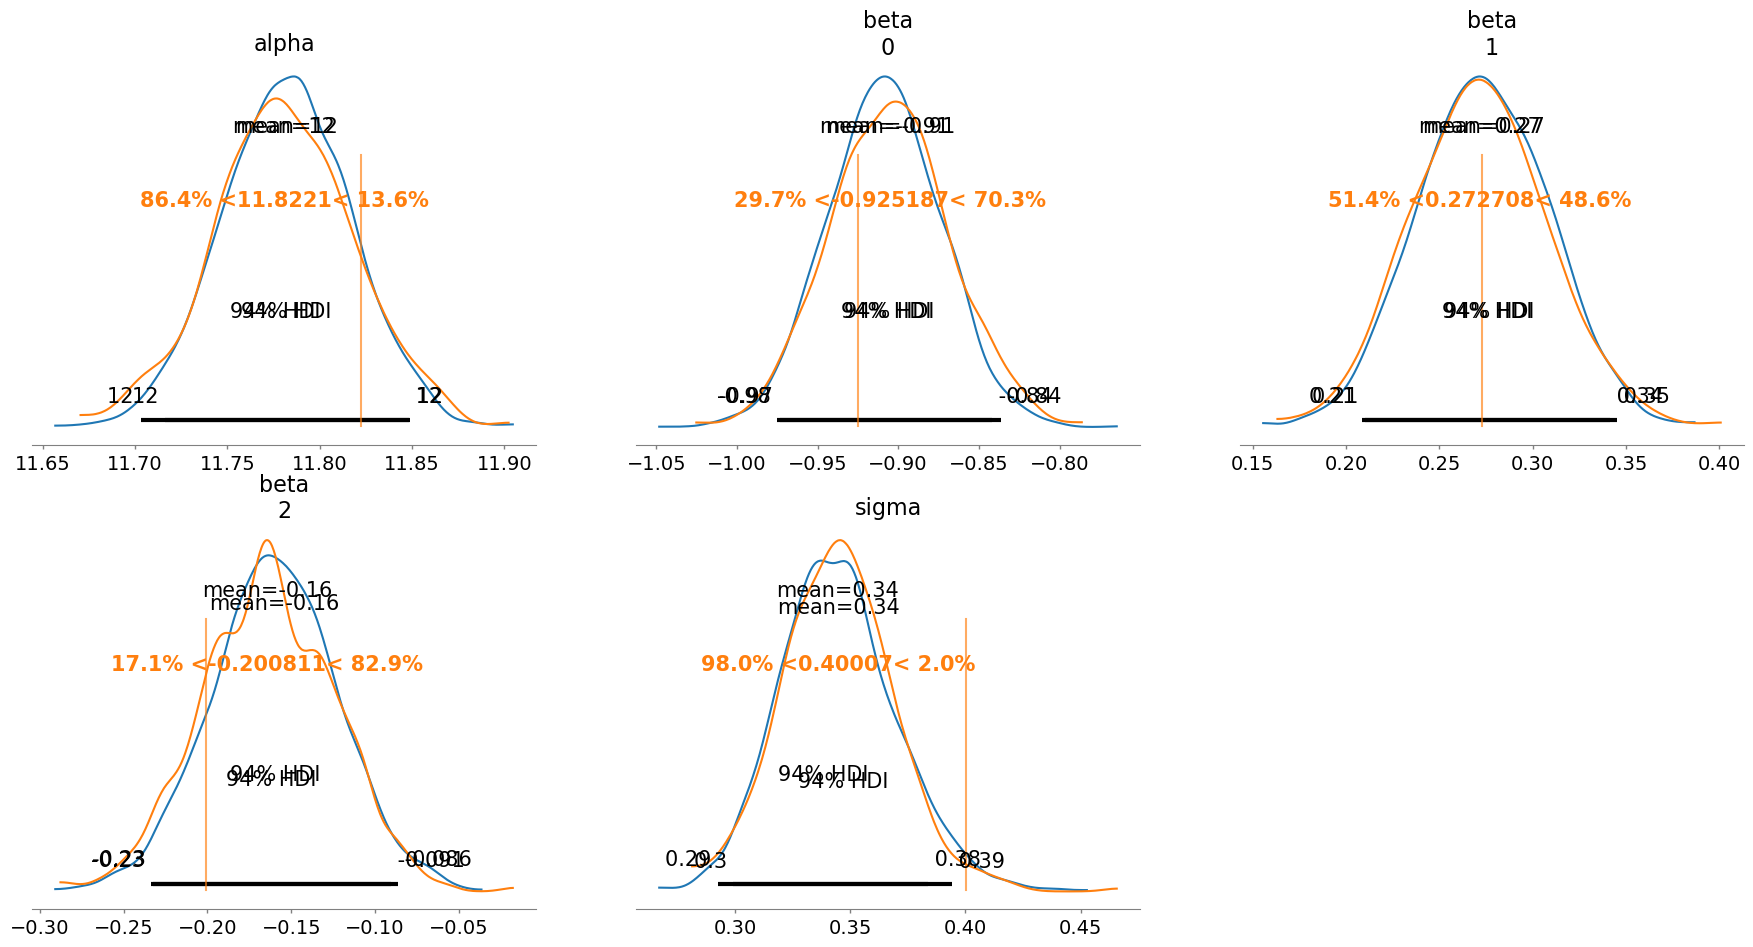

In [18]:
var_names = ["alpha", "beta", "sigma"]
axes = az.plot_posterior(idata, color="tab:blue", var_names=var_names)
az.plot_posterior(
    idata_vi,
    color="tab:orange",
    var_names=var_names,
    ref_val=np.r_[*[true_params[v] for v in var_names]].tolist(),
    ax=axes,
)

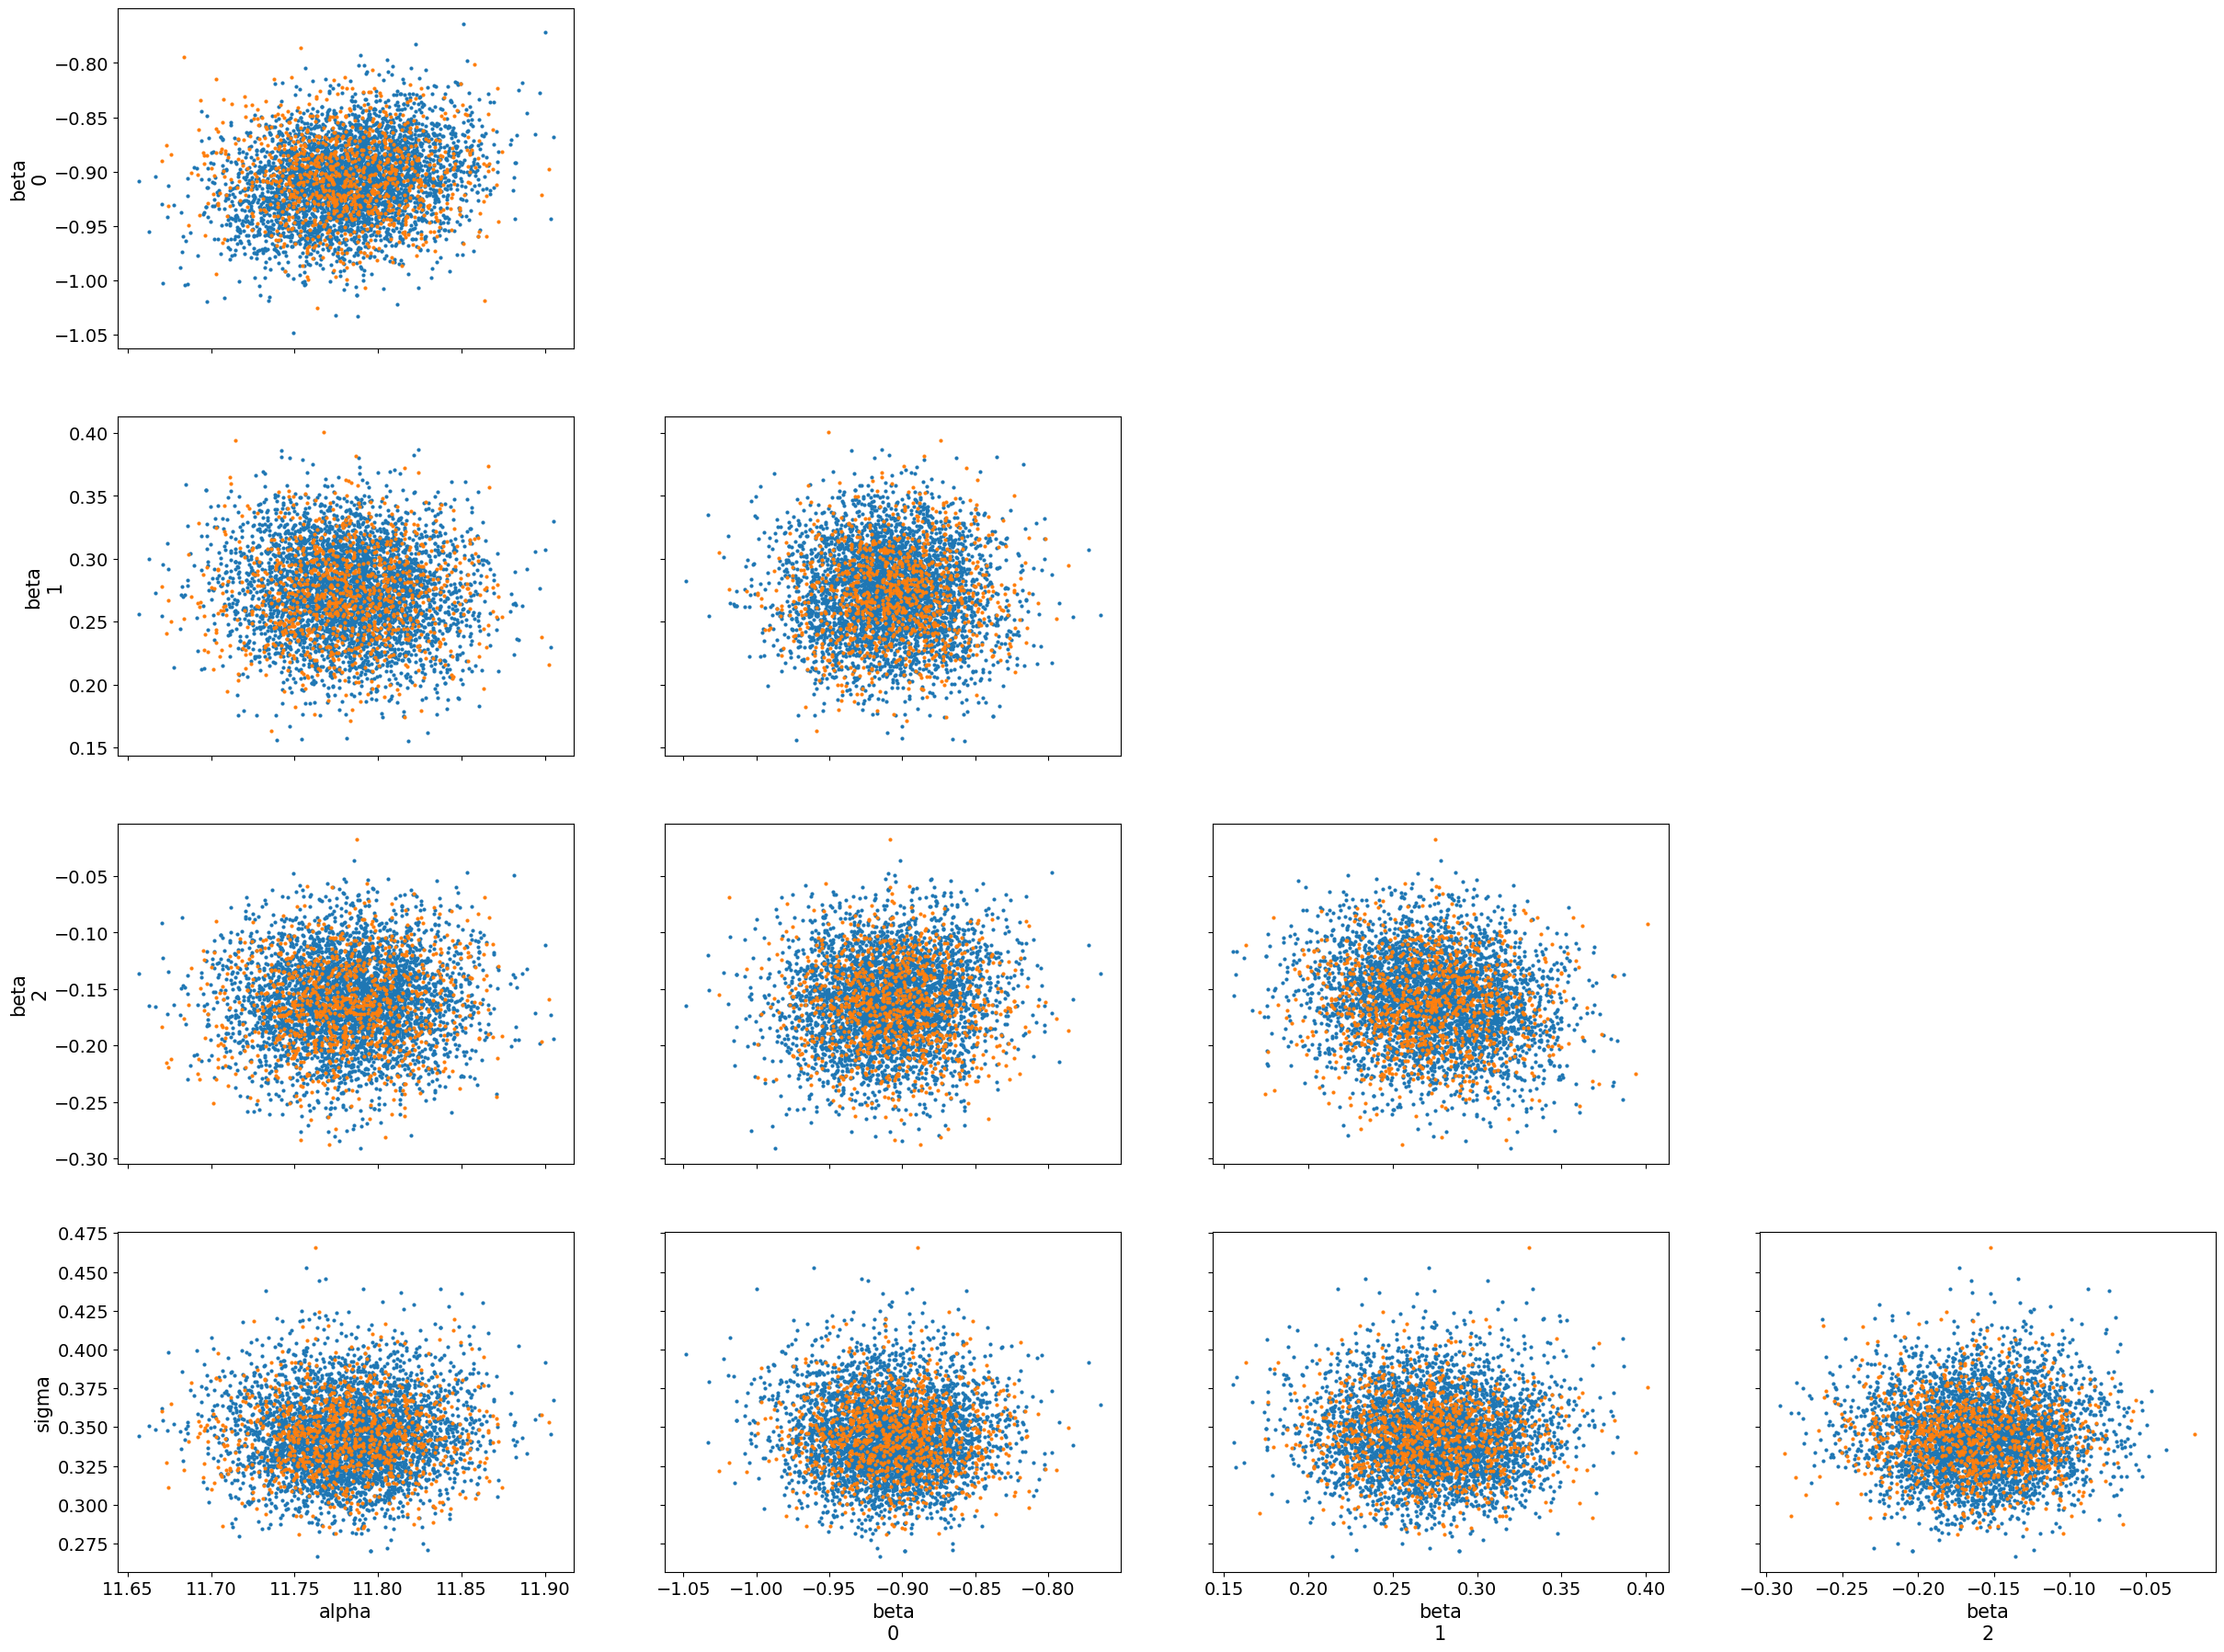

In [19]:
axes = az.plot_pair(idata, var_names=var_names)
az.plot_pair(idata_vi, var_names=var_names, ax=axes)
plt.show()

## Todo:

- Does this "two models" frameworks fits into what we already have?
- rsample --> stochastic gradients? Or automatic reparameterization?
- figure out guide param initalization
- More flexible optimizers...

# Radon Example

In [20]:
import pandas as pd
import os

try:
    srrs2 = pd.read_csv(os.path.join("..", "data", "srrs2.dat"))
except FileNotFoundError:
    srrs2 = pd.read_csv(pm.get_data("srrs2.dat"))

srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

try:
    cty = pd.read_csv(os.path.join("..", "data", "cty.dat"))
except FileNotFoundError:
    cty = pd.read_csv(pm.get_data("cty.dat"))

srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

srrs_mn.county = srrs_mn.county.map(str.strip)
county, mn_counties = srrs_mn.county.factorize()
srrs_mn["county_code"] = county
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

coords = {"county": mn_counties, "obs_id": np.arange(srrs_mn.shape[0])}

In [21]:
coords["param"] = ["alpha", "beta"]
coords["param_bis"] = ["alpha", "beta"]

with pm.Model(coords=coords) as covariation_intercept_slope:
    floor_idx = pm.Data("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.Data("county_idx", county, dims="obs_id")

    # prior stddev in intercepts & slopes (variation across counties):
    sd_dist = pm.Exponential.dist(0.5, shape=(2,))

    # get back standard deviations and rho:
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=2.0, sd_dist=sd_dist)

    # prior for average intercept:
    mu_alpha_beta = pm.Normal("mu_alpha", mu=0.0, sigma=5.0, shape=2)
    # prior for average slope:
    mu_beta = pm.Normal("mu_beta", mu=0.0, sigma=1.0)
    # population of varying effects:
    alpha_beta_county = pm.MvNormal(
        "alpha_beta_county", mu=mu_alpha_beta, chol=chol, dims=("county", "param")
    )

    # Expected value per county:
    theta = alpha_beta_county[county_idx, 0] + alpha_beta_county[county_idx, 1] * floor_idx
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

In [22]:
import numpy as np


class RMSPropOptimizer:
    def __init__(
        self,
        lr_start: float = 1e-6,
        lr_peak: float = 1e-3,
        warmup_steps: int = 5_000,
        total_steps: int = 20_000,
        decay: float = 0.9,
        eps: float = 1e-8,
    ):
        self.lr_start = lr_start
        self.lr_peak = lr_peak
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.decay = decay
        self.eps = eps

    def init(self, params: dict[str, np.ndarray]) -> tuple[int, dict[str, np.ndarray]]:
        step = 0
        avg_sq = {k: np.zeros_like(v) for k, v in params.items()}
        return step, avg_sq

    def _lr(self, step: int) -> float:
        if step < self.warmup_steps:
            # Linear warmup
            return self.lr_start + (self.lr_peak - self.lr_start) * (step / self.warmup_steps)

        # Cosine decay from lr_peak -> 0
        denom = max(1, self.total_steps - self.warmup_steps)
        t = (step - self.warmup_steps) / denom
        t = min(max(t, 0.0), 1.0)

        return 0.5 * self.lr_peak * (1.0 + np.cos(np.pi * t))

    def update(
        self,
        grads: dict[str, np.ndarray],
        state: tuple[int, dict[str, np.ndarray]],
        params: dict[str, np.ndarray],
    ) -> tuple[dict[str, np.ndarray], tuple[int, dict[str, np.ndarray]]]:
        step, avg_sq = state
        lr = self._lr(step)

        new_avg_sq: dict[str, np.ndarray] = {}
        updated_params: dict[str, np.ndarray] = {}

        for k, p in params.items():
            g = grads[k]
            v = avg_sq[k]

            # Exponential moving average of squared gradients
            v_new = self.decay * v + (1.0 - self.decay) * (g * g)

            # RMSProp parameter update
            p_new = p - lr * g / (np.sqrt(v_new) + self.eps)

            new_avg_sq[k] = v_new
            updated_params[k] = p_new

        return updated_params, (step + 1, new_avg_sq)


class NormalModel(SVIModule):
    def configure_guide(self, model):
        return AutoDiagonalNormal(model)

    def configure_optimizer(self, params: dict[str, np.ndarray]) -> tuple[Any, dict[str, Any]]:
        optimizer = RMSPropOptimizer(
            lr_start=1e-5, lr_peak=1e-3, warmup_steps=1_000, total_steps=10_000
        )
        opt_state = optimizer.init(params)
        return optimizer, opt_state

    def apply_gradients(
        self,
        params: dict[str, np.ndarray],
        grads: dict[str, np.ndarray],
        optimizer: Any,
        optimizer_state: dict[str, Any],
    ):
        updated_params, updated_opt_state = optimizer.update(grads, optimizer_state, params)
        return updated_params, updated_opt_state

In [23]:
svi_trainer = SVITrainer(
    module=NormalModel(), compile_kwargs={"mode": "NUMBA"}, stick_the_landing=True
)
svi_state = svi_trainer.fit(n_steps=20_000, model=covariation_intercept_slope, draws_per_step=100)

Output()

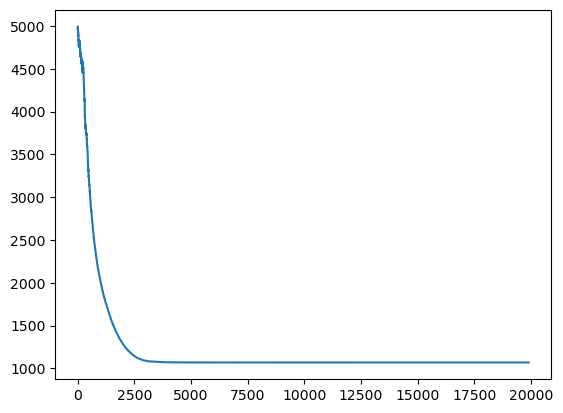

In [24]:
plot_loss_history(svi_state)

In [25]:
with covariation_intercept_slope:
    varying_intercept_trace = svi_trainer.sample_posterior(draws=2000, state=svi_state)

In [26]:
with covariation_intercept_slope:
    idata_mcmc = pm.sample(nuts_sampler="nutpie")

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.35,31
,2000,0,0.39,15
,2000,0,0.28,31
,2000,42,0.12,31


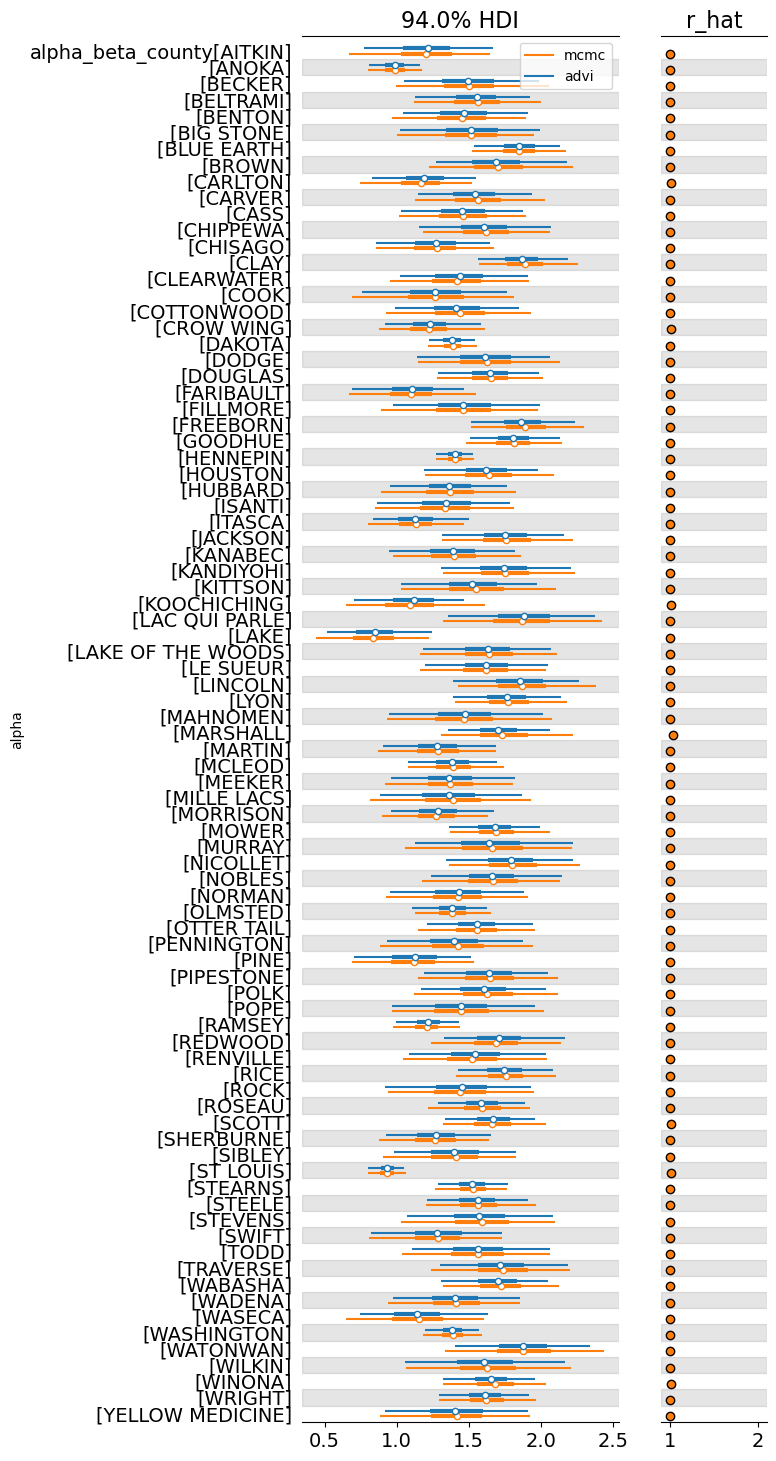

In [27]:
ax = az.plot_forest(
    [varying_intercept_trace, idata_mcmc],
    var_names=["alpha_beta_county"],
    r_hat=True,
    combined=True,
    figsize=(6, 18),
    labeller=az.labels.NoModelLabeller(),
    coords={"param": "alpha"},
    model_names=["advi", "mcmc"],
)
ax[0].set_ylabel("alpha");